In [1]:
%run setup.py

# Read in Kepler sample

In [2]:
stars = pd.read_excel(work_dir+'sample/clumps.xlsx')

In [3]:
# Select all very-low-mass HeB stars
lidx = (stars['Phase']==2) & (stars['ifclump']==1) & (np.abs(stars['dist_mass_sig'])>1)

# Select all under-luminous HeB stars
uidx = (stars['Phase']==2) & (stars['ifclump']==2) & (np.abs(stars['dist_nike_sig'])>1)

# Select regular HeB stars
ridx = (stars['Phase']==2) & (stars['ifclump']!=-1) & (~lidx) & (~uidx)

# all stars
heb = lidx | uidx | ridx

# Select young-alpha-rich stars
yidx = (stars['Phase']==2) & (stars['ClcorM']>1.5) & (stars['ALPHA_M']>0.15)

# Select old-alpha-poor stars
oidx = (stars['Phase']==2) & (stars['ClcorM']<0.8) & (stars['ALPHA_M']<0.03)

print('very-low-mass stars', np.sum(lidx))
print('under-luminous stars', np.sum(uidx))
print('regular stars', np.sum(ridx))
print('all HeB stars', np.sum(heb))
print('all HeB stars with APOGEE/LAMOST metallicity', np.sum(heb&np.isfinite(stars['[M/H]'])))
print('young-alpha-rich stars', np.sum(yidx))
print('old-alpha-poor stars', np.sum(oidx))

very-low-mass stars 32
under-luminous stars 7
regular stars 7499
all HeB stars 7538
all HeB stars with APOGEE/LAMOST metallicity 6612
young-alpha-rich stars 51
old-alpha-poor stars 22


In [29]:
stars.loc[lidx | uidx,:].reset_index(drop=True).to_excel('stripped_clumps.xlsx')

# Read in RV data
APOGEE DR17, LAMOST MRS

In [4]:
from astropy.io import fits

f = fits.open(work_dir+'sample/yu+2018_x_zhang+21.fits')
zhang = f[1].data
f.close()

f = fits.open(work_dir+'sample/yu+2018_x_sdss_dr17_allvisit.fits')
apogee = f[1].data
f.close()

In [5]:
for istar, star in stars.iterrows():
    idxa = np.isin(zhang['KIC'], star['KIC'])
    idxb = np.isin(apogee['KIC'], star['KIC'])
    if np.sum(idxa)+np.sum(idxb)>=2:
        pass
    else:
        continue
        
    Tmin = np.min(np.concatenate([zhang['bjdmid'][idxa], apogee['JD'][idxb]]))
    time = np.concatenate([zhang['bjdmid'][idxa]-Tmin, apogee['JD'][idxb]-Tmin])
    rv = np.concatenate([zhang['rv_B'][idxa], apogee['VHELIO'][idxb]])
    erv = np.concatenate([zhang['rv_err_B'][idxa], ((3.5*apogee['VRELERR'][idxb]**1.2)**2.0 + 0.072**2.)**0.5 ])
#     erv = np.concatenate([zhang['rv_err_B'][idxa], apogee['VRELERR'][idxb] ])
    
    
    stars.loc[istar,'diff_rv'] = np.abs(np.max(rv)-np.min(rv))
    stars.loc[istar,'e_rv'] = np.median(erv)

# Read in simulated binary sample

In [6]:
# The parameters are generated according to known binary distributions (Moe & Di Stefano, 2017)
data = pd.read_csv(work_dir+'sample/simulated_binaries.csv')

In [7]:
data

,Unnamed: 0,M1,M2,q,maxR,P,R_L1,f_binary
0,0,1.00,0.358913,0.358913,147.536878,4.448619e+03,4305.611858,0.367065
1,1,1.75,1.006160,0.574948,109.630637,5.980883e+03,7484.282971,0.409512
2,2,1.67,0.520382,0.311606,128.238858,2.497327e+06,330993.641213,0.404909
3,3,1.58,1.576810,0.997981,129.446810,6.057985e+00,90.055678,0.399708
4,4,0.95,0.943939,0.993620,167.224664,1.137449e+04,11548.296434,0.364550
...,...,...,...,...,...,...,...,...
7287,7287,1.20,0.415646,0.346372,145.713175,9.718687e+03,7608.476382,0.377873
7288,7288,1.35,1.156461,0.856638,193.402990,3.433532e+05,118773.870562,0.386407
7289,7289,1.37,0.615591,0.449337,146.381401,2.434374e+04,16077.664537,0.387559
7290,7290,0.84,0.384860,0.458167,134.190831,2.969536e+05,72885.325234,0.359460


## Overflow binary

In [8]:
# 1 - overflow binary
idx = data['maxR']>data['R_L1']

P = np.array(data.loc[idx,'P']) *24*60*60 # day to s
fbinary1 = np.array(data.loc[idx,'f_binary'])
Mtotal = np.array(data.loc[idx,'M1'])+np.array(data.loc[idx,'M2']) * 1.989e+30 # Msun to kg
G = 6.67408 * 1e-11 # m^3 kg-1 s-2
a = ((P/(2*np.pi))**2.0 * (G*(Mtotal)) )**(1/3.)
Vmax = 2*np.pi*a/P *1e-3 # m/s to km/s

Nstar = len(P)
inclination = np.arcsin(np.random.rand(Nstar))
RVmax = Vmax*np.sin(inclination) 

rand = np.array(np.random.rand(Nstar)*len(rv_obs_data),dtype=int)

diff_rv1, e_rv1 = [np.zeros(Nstar) for i in range(2)]

for istar in range(Nstar):
    time = rv_obs_data[rand[istar]]['JD']
    erv = ((3.5*rv_obs_data[rand[istar]]['VRELERR']**1.2)**2.0 + 0.072**2.)**0.5
#     erv = rv_obs_data[rand[istar]]['VRELERR']
    rv = RVmax[istar]*np.sin(2*np.pi/(P[istar]/24/60/60) * (time)) + np.random.randn(len(time))*erv
    
    diff_rv1[istar] = np.abs(np.max(rv)-np.min(rv))
    e_rv1[istar] = np.median(erv)

NameError: name 'rv_obs_data' is not defined

In [ ]:
idx = (data['maxR']>data['R_L1']) & (data['M1']<3.6) &  (data['M1']>1.8)
Nstar_right_of_ZAHeB = np.sum(idx*data.loc[idx,'f_binary']) 
print('Number of stars expected on the right of ZAHeB edge:', Nstar_right_of_ZAHeB)

idx = (data['maxR']>data['R_L1']) & (data['M1']<1.8)
Nstar_left_of_ZAHeB = np.sum(idx*data.loc[idx,'f_binary']) 
print('Number of stars expected on the left of ZAHeB edge:', Nstar_left_of_ZAHeB)

## Not flow binary

In [ ]:
# 3 - not flow binary
idx = data['maxR']< (2*data['R_L1'])

P = np.array(data.loc[idx,'P']) *24*60*60 # day to s
fbinary3 = np.array(data.loc[idx,'f_binary'])
Mtotal = np.array(data.loc[idx,'M1'])+np.array(data.loc[idx,'M2']) * 1.989e+30 # Msun to kg
G = 6.67408 * 1e-11 # m^3 kg-1 s-2
a = ((P/(2*np.pi))**2.0 * (G*(Mtotal)) )**(1/3.)
Vmax = 2*np.pi*a/P *1e-3 # m/s to km/s

Nstar = len(P)
inclination = np.arcsin(np.random.rand(Nstar))
RVmax = Vmax*np.sin(inclination) 

rand = np.array(np.random.rand(Nstar)*len(rv_obs_data),dtype=int)


diff_rv3, e_rv3 = [np.zeros(Nstar) for i in range(2)]

for istar in range(Nstar):
    time = rv_obs_data[rand[istar]]['JD']
    erv = ((3.5*rv_obs_data[rand[istar]]['VRELERR']**1.2)**2.0 + 0.072**2.)**0.5
#     erv = rv_obs_data[rand[istar]]['VRELERR']
    rv = RVmax[istar]*np.sin(2*np.pi/(P[istar]/24/60/60) * (time)) + np.random.randn(len(time))*erv
    
    diff_rv3[istar] = np.abs(np.max(rv)-np.min(rv))
    e_rv3[istar] = np.median(erv)

## Single star

In [ ]:
Nstar = 7073

rand = np.array(np.random.rand(Nstar)*len(rv_obs_data),dtype=int)

# 2 - single star
diff_rv2, e_rv2 = [np.zeros(Nstar) for i in range(2)]

for istar in range(Nstar):
    time = rv_obs_data[rand[istar]]['JD']
    erv = ((3.5*rv_obs_data[rand[istar]]['VRELERR']**1.2)**2.0 + 0.072**2.)**0.5
#     erv = rv_obs_data[rand[istar]]['VRELERR']
    rv = np.random.randn(len(time))*erv
    diff_rv2[istar] = np.abs(np.max(rv)-np.min(rv))
    e_rv2[istar] = np.median(erv)

# Plot Extended Figure 5 - RV distributions

In [ ]:
%matplotlib inline

gridspec_kw = {'left':0.17, 'right':0.96, 'top':0.98, 'bottom':0.09, 'wspace':0.2, 'hspace':0.}
fig, axes = plt.subplots(figsize=nature_size(column="one", ratio=1.4), nrows=4, ncols=1, squeeze=False, gridspec_kw=gridspec_kw)
axes = axes.reshape(-1)

from matplotlib.ticker import ScalarFormatter


histtype ={'histtype':'step'}

# bins = np.arange(0,200,1)
bins = np.logspace(np.log10(0.1), np.log10(3000), 20, base=10)
axes[0].hist(stars.loc[uidx,'diff_rv']/stars.loc[uidx,'e_rv'], bins=bins, color=red, linestyle='-', label='Under-luminous', **histtype)
axes[0].hist(stars.loc[lidx,'diff_rv']/stars.loc[lidx,'e_rv'], bins=bins, color=blue, linestyle='--', label='Very-low-mass', **histtype)
axes[1].hist(stars.loc[yidx,'diff_rv']/stars.loc[yidx,'e_rv'], bins=bins, color=lightred, linestyle='-', label='$M>1.5$ $M_{\odot}$, [$\\alpha$/M]$>0.15$', **histtype)
axes[1].hist(stars.loc[oidx,'diff_rv']/stars.loc[oidx,'e_rv'], bins=bins, color=lightblue, linestyle='--', label='$M<0.8$ $M_{\odot}$, [$\\alpha$/M]$<0.03$', **histtype)


iaxes = [0, 0, 1, 1]
idxes = [uidx, lidx, yidx, oidx]
colors = [red, blue, lightred, lightblue]
ys = [0.55, 0.4, 0.55, 0.4]
for i in range(4):
    iax, idx, color, y = iaxes[i], idxes[i], colors[i], ys[i]
    axes[iax].text(0.99, y, 'Median: {:0.2f} $\\pm$ {:0.2f}'.format(np.nanmedian(stars.loc[idx,'diff_rv']/stars.loc[idx,'e_rv']),
                                                                   np.nanstd(stars.loc[idx,'diff_rv']/stars.loc[idx,'e_rv'])/len(stars.loc[idx,'diff_rv'])), 
                   color=color, ha='right', va='center', transform=axes[iax].transAxes, fontsize=fontsize)


axes[2].hist(stars.loc[ridx,'diff_rv']/stars.loc[ridx,'e_rv'], bins=bins, color='k', linestyle='-', label='Observed Kepler HeB stars', **histtype) #density=True, 


axes[2].text(0.99, 0.7, 'Median: {:0.2f} $\\pm$ {:0.2f}'.format(np.nanmedian(stars.loc[ridx,'diff_rv']/stars.loc[ridx,'e_rv']),
                                                               np.nanstd(stars.loc[ridx,'diff_rv']/stars.loc[ridx,'e_rv'])/len(stars.loc[ridx,'diff_rv'])), 
               color='k', ha='right', va='center', transform=axes[2].transAxes, fontsize=fontsize)

axes[3].hist(diff_rv3/e_rv3, bins=bins, color='k', linestyle='-', label='Simulated binary stars', **histtype)
axes[3].hist(diff_rv2/e_rv2, bins=bins, color='k', linestyle='--', label='Simulated single stars', **histtype)



labels = ['{\\textbf{a}}', '{\\textbf{b}}', '{\\textbf{c}}', '{\\textbf{d}}']
for iax in range(len(axes)):
    axes[iax].text(0.06, 0.84, labels[iax], transform=axes[iax].transAxes, fontsize=fontsize)
    axes[iax].get_xaxis().set_major_formatter(ScalarFormatter())
    axes[iax].set_ylabel('Count')
    axes[iax].legend(fontsize=fontsize)
    axes[iax].set_xscale('log')
    axes[iax].set_xlabel('$|{\\rm RV}_{\\rm max}-{\\rm RV}_{\\rm min}|/e_{\\rm RV}$')

axes[1].set_ylim(0., 7.5)
axes[2].set_ylim(0., 700)
axes[-1].set_ylim(0., 2200)
plt.savefig(overleaf_path+'Fig_extended_5_rv_hist.pdf')

In [ ]:
print('Observed Kepler sample median {:0.2f} +/- {:0.2f}'.format(np.nanmedian(stars.loc[ridx,'diff_rv']/stars.loc[ridx,'e_rv']), np.nanstd(stars.loc[ridx,'diff_rv']/stars.loc[ridx,'e_rv'])/len(stars.loc[ridx,'diff_rv'])))
print('Under-luminous median {:0.2f} +/- {:0.2f}'.format(np.nanmedian(stars.loc[uidx,'diff_rv']/stars.loc[uidx,'e_rv']), np.nanstd(stars.loc[uidx,'diff_rv']/stars.loc[uidx,'e_rv'])/len(stars.loc[uidx,'diff_rv'])))
print('Very-low-mass median {:0.2f} +/- {:0.2f}'.format(np.nanmedian(stars.loc[lidx,'diff_rv']/stars.loc[lidx,'e_rv']), np.nanstd(stars.loc[lidx,'diff_rv']/stars.loc[lidx,'e_rv'])/len(stars.loc[lidx,'diff_rv'])))
print('Low-alpha median {:0.2f} +/- {:0.2f}'.format(np.nanmedian(stars.loc[yidx,'diff_rv']/stars.loc[yidx,'e_rv']), np.nanstd(stars.loc[yidx,'diff_rv']/stars.loc[yidx,'e_rv'])/len(stars.loc[yidx,'diff_rv'])))
print('High-alpha median {:0.2f} +/- {:0.2f}'.format(np.nanmedian(stars.loc[oidx,'diff_rv']/stars.loc[oidx,'e_rv']), np.nanstd(stars.loc[oidx,'diff_rv']/stars.loc[oidx,'e_rv'])/len(stars.loc[oidx,'diff_rv'])))

In [22]:
idx = lidx & ((stars['diff_rv']/stars['e_rv'])>10)
stars.loc[idx,['KIC', 'Kpmag', 'diff_rv', 'e_rv']]

,KIC,Kpmag,diff_rv,e_rv
1757,3963011,13.63,NaN,NaN
2794,4755614,11.48,0.134182,0.080230
3164,5000307,11.23,0.129131,0.084300
8658,8145590,9.79,0.140252,0.079098
9347,8489112,13.52,NaN,NaN
13270,10665157,14.06,NaN,NaN
13381,10724735,12.48,NaN,NaN


In [ ]:

        
    Tmin = np.min(np.concatenate([zhang['bjdmid'][idxa], apogee['JD'][idxb]]))
    time = np.concatenate([zhang['bjdmid'][idxa]-Tmin, apogee['JD'][idxb]-Tmin])
    rv = np.concatenate([zhang['rv_B'][idxa], apogee['VHELIO'][idxb]])
    erv = np.concatenate([zhang['rv_err_B'][idxa], ((3.5*apogee['VRELERR'][idxb]**1.2)**2.0 + 0.072**2.)**0.5 ])
#     erv = np.concatenate([zhang['rv_err_B'][idxa], apogee['VRELERR'][idxb] ])

<ErrorbarContainer object of 3 artists>

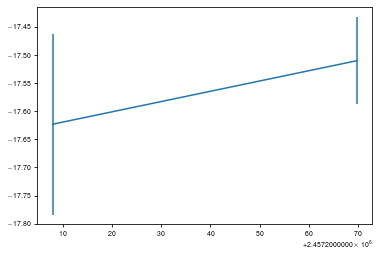

In [18]:
idx = apogee['KIC']==8245132
plt.errorbar(apogee['JD'][idx], apogee['VHELIO'][idx],
             yerr=((3.5*apogee['VRELERR'][idx]**1.2)**2.0 + 0.072**2.)**0.5 , )

<ErrorbarContainer object of 3 artists>

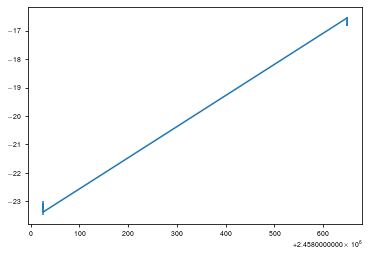

In [19]:
idx = zhang['KIC']==8245132
plt.errorbar(zhang['bjdmid'][idx], zhang['rv_B'][idx],
             yerr=zhang['rv_err_B'][idx], )

In [20]:
zhang

FITS_rec([( 4136835, 12.39, 18, 1317.9, 78.44, 0.92, 7.158, 0.011, 42. , 26.9, 2.1,  259.6,  50.6, 4909,  80, 2.807, 0.008, -0.62, 0.15, 1.63, 0.09,  8.34, 0.17, 1.47, 0.08,  7.92, 0.16, 1.64, 0.09,  8.37, 0.17, 1, 'M17', 'Simbad', 284.96854, 39.2975881, 591702204, 83564363, 2458030.97871339, 'HIP9380801', 2, 204, 284.96854, 39.297588, 23.9 , 38.73, 'sc', 'sc', -54.12069448, 1.48781228e-01, 5.33045431e+03, 8.80967288e-01, -52.56551635, 0.2764197 , 4790.93814546, 0.83096848, -52.24178381, 0.33117773, 5330.45431058, 0.7010119 ,    1, 3, 0.00036),
          ( 4136835, 12.39, 18, 1317.9, 78.44, 0.92, 7.158, 0.011, 42. , 26.9, 2.1,  259.6,  50.6, 4909,  80, 2.807, 0.008, -0.62, 0.15, 1.63, 0.09,  8.34, 0.17, 1.47, 0.08,  7.92, 0.16, 1.64, 0.09,  8.37, 0.17, 1, 'M17', 'Simbad', 284.96854, 39.2975881, 591702204, 83564350, 2458030.96944299, 'HIP9380801', 2, 204, 284.96854, 39.297588, 24.53, 40.23, 'sc', 'sc', -53.60096472, 1.79816405e-01, 5.33045431e+03, 8.90349664e-01, -52.46243806, 0.2990679

In [25]:

# f = fits.open(work_dir+'sample/yu+2018_x_zhang+21.fits')
# zhang = f[1].data
# # f.close()

f = fits.open(work_dir+'sample/yu+2018_x_sdss_dr17_allvisit.fits')
apogee = f[1].data
# f.close()
f[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                 1219 / width of table in bytes                        
NAXIS2  =                21787 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                  131 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'KIC     '           / label for column 1                             
TFORM1  = 'J       '           / format for column 1                            
TTYPE2  = 'Kpmag   '           / label for column 2                             
TFORM2  = 'E       '        